In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [2]:
forecast_demand_file_path = '../data/forecastdemand_nsw.csv'
actual_demand_file_path = '../data/totaldemand_nsw.csv'
temperature_file_path = '../data/temperature_nsw.csv'
forecast_demand = pd.read_csv(forecast_demand_file_path)
actual_demand = pd.read_csv(actual_demand_file_path)
temperature = pd.read_csv(temperature_file_path)

Exports_file_path = '../data/Exports - quarterly 2010-2023.csv'
GDP_file_path = '../data/GDP - quarterly 2010-2023.csv'
Interest_file_path = '../data/Interest rate - daily 2011-2023.csv'
SolarInstall_file_path = '../data/Solar installation number - monthly 2007-2023.csv'
SolarOutput_file_path = '../data/Solar outputs - monthly 2015-2023.csv'
Unemployment_file_path = '../data/Unemployment rate - monthly 2010-2023.csv'
Wholesale_file_path = '../data/Wholesale electricity price - half hourly 2014-2023.csv'
cpi_file_path = '../data/inflation-data.xls'
comm_file_path = '../data/Commodity prices index - monthly 2010-2023.csv'
rainfall_file_path = '../data/Rainfall - daily 2010-2023.csv'
weather_file_path = '../data/Weather - daily 2022-2023.csv'
SolarExposure_file_path = '../data/Solar exposure - daily 2010-2023.csv'

cpi = pd.read_excel(cpi_file_path)
Exports = pd.read_csv(Exports_file_path)
GDP = pd.read_csv(GDP_file_path)
Interest = pd.read_csv(Interest_file_path)
SolarInstall = pd.read_csv(SolarInstall_file_path)
SolarOutput = pd.read_csv(SolarOutput_file_path)
Unemployment = pd.read_csv(Unemployment_file_path)
Wholesale = pd.read_csv(Wholesale_file_path)
Comm = pd.read_csv(comm_file_path)
Rainfall = pd.read_csv(rainfall_file_path)
Weather = pd.read_csv(weather_file_path)
SolarExposure = pd.read_csv(SolarExposure_file_path)

In [3]:
path = '../data/nswdemand2022onwards'
all_files = glob.glob(os.path.join(path, "*.csv"))

total_demand_2022onwards = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [4]:
lag_value = -6
test_date = '2020-11-30'

In [5]:
temperature.loc[temperature['TEMPERATURE'] <= -5, 'TEMPERATURE'] = np.nan
df = pd.DataFrame({'Date Time': actual_demand['DATETIME'], 'Total Demand': actual_demand['TOTALDEMAND']})
df = pd.merge(df,temperature,left_on=['Date Time'], right_on=['DATETIME'], how = 'left')
df=df.drop(columns=['DATETIME', 'LOCATION'])
df['TEMPERATURE'] = df['TEMPERATURE'].interpolate(method='linear')
df['Date Time'] = pd.to_datetime(df['Date Time'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
forecast_demand['LASTCHANGED'] = pd.to_datetime(forecast_demand['LASTCHANGED'])
forecast_demand['TIME_DIFF'] = forecast_demand['DATETIME'] - forecast_demand['LASTCHANGED']
forecast_demand = forecast_demand[forecast_demand['TIME_DIFF'] >= pd.Timedelta(hours=6)]
forecast_demand = forecast_demand.drop(columns=['TIME_DIFF'])
fore = forecast_demand.set_index('DATETIME').resample('1H').mean()[['FORECASTDEMAND']]
actu = actual_demand.set_index('DATETIME').resample('1H').mean()[['TOTALDEMAND']]
merged_df = fore.join(actu).dropna()
merged_df['DIFF'] = merged_df.eval('TOTALDEMAND - FORECASTDEMAND')
merged_df['Demand_Previous'] = merged_df['TOTALDEMAND'].shift(periods=(-24))
merged_df['Demand_Lagged'] = merged_df['TOTALDEMAND'].shift(periods=(lag_value))
merged_df['Demand_Rolling'] = merged_df['Demand_Lagged'].rolling(window=168).mean()

temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temp = temperature.set_index('DATETIME').resample('1H').mean()
temp['TEMPERATURE_lagged'] = temp['TEMPERATURE'].shift(periods=lag_value)
data = merged_df.merge(temp, left_index=True, right_index=True, how='inner')
data = data.drop(['LOCATION','TEMPERATURE', 'FORECASTDEMAND', 'DIFF'], axis=1)
df = data.dropna()

column_rename_mapping = {
    'G1 CONSUMER PRICE INFLATION': 'DATETIME',
    'Unnamed: 1': 'cpi'
}
cpi = cpi.rename(columns=column_rename_mapping)[10:].dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
cpi.index = pd.to_datetime(cpi.index, format='%b-%Y')
cpi = cpi[(cpi.index >= min_date) & (cpi.index <= max_date)]
cpi = cpi.reindex(date_range).fillna(method='ffill')
cpi['CPI_lagged'] = cpi['cpi'].shift(periods=lag_value)
cpi = cpi[['CPI_lagged']]
df = pd.concat([df, cpi], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Exports of goods and services': 'Exports'
}
Exports = Exports.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Exports.index = pd.to_datetime(Exports.index, format='%b-%Y')
Exports = Exports[(Exports.index >= min_date) & (Exports.index <= max_date)]
Exports = Exports.reindex(date_range).fillna(method='ffill')
Exports['Exports_lagged'] = Exports['Exports'].shift(periods=lag_value)
Exports = Exports[['Exports_lagged']]
df = pd.concat([df, Exports], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Real GDP': 'GDP'
}
GDP = GDP.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
GDP.index = pd.to_datetime(GDP.index, format='%b-%Y')
GDP = GDP[(GDP.index >= min_date) & (GDP.index <= max_date)]
GDP = GDP.reindex(date_range).fillna(method='ffill')
GDP['GDP_lagged'] = GDP['GDP'].shift(periods=lag_value)
GDP = GDP[['GDP_lagged']]
df = pd.concat([df, GDP], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Cash Rate Target': 'Interest'
}
Interest = Interest.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Interest.index = pd.to_datetime(Interest.index)
Interest = Interest[(Interest.index >= min_date) & (Interest.index <= max_date)]
Interest = Interest.reindex(date_range).fillna(method='ffill')
Interest['Interest_lagged'] = Interest['Interest'].shift(periods=lag_value)
Interest = Interest[['Interest_lagged']]
df = pd.concat([df, Interest], axis=1).dropna()

column_rename_mapping = {
    "'Month'": 'DATETIME',
    'Cumulative Residential': 'Residential',
    'Cumulative Commercial': 'Commercial'
}
SolarInstall = SolarInstall.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarInstall.index = pd.to_datetime(SolarInstall.index)
SolarInstall = SolarInstall[(SolarInstall.index >= min_date) & (SolarInstall.index <= max_date)]
SolarInstall = SolarInstall.reindex(date_range).fillna(method='ffill')
SolarInstall['Residential_lagged'] = SolarInstall['Residential'].shift(periods=lag_value)
SolarInstall['Commercial_lagged'] = SolarInstall['Commercial'].shift(periods=lag_value)
SolarInstall = SolarInstall[['Residential_lagged','Commercial_lagged']]
df = pd.concat([df, SolarInstall], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Output NSW': 'SolarOutput'
}
SolarOutput = SolarOutput.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarOutput.index = pd.to_datetime(SolarOutput.index)
SolarOutput = SolarOutput[(SolarOutput.index >= min_date) & (SolarOutput.index <= max_date)]
SolarOutput = SolarOutput.reindex(date_range).fillna(method='ffill')
SolarOutput['SolarOutput_lagged'] = SolarOutput['SolarOutput'].shift(periods=lag_value)
SolarOutput = SolarOutput[['SolarOutput_lagged']]
df = pd.concat([df, SolarOutput], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Unemployment rate': 'Unemployment'
}
Unemployment = Unemployment.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Unemployment.index = pd.to_datetime(Unemployment.index, format='%b-%Y')
Unemployment = Unemployment[(Unemployment.index >= min_date) & (Unemployment.index <= max_date)]
Unemployment = Unemployment.reindex(date_range).fillna(method='ffill')
Unemployment['Unemployment_lagged'] = Unemployment['Unemployment'].shift(periods=lag_value)
Unemployment = Unemployment[['Unemployment_lagged']]
df = pd.concat([df, Unemployment], axis=1).dropna()

column_rename_mapping = {
    "SETTLEMENTDATE": 'DATETIME',
    'RRP': 'Price'
}
Wholesale = Wholesale.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Wholesale.index = pd.to_datetime(Wholesale.index, format='%Y/%m/%d %H:%M:%S')
Wholesale = Wholesale[(Wholesale.index >= min_date) & (Wholesale.index <= max_date)]
Wholesale = Wholesale.reindex(date_range).fillna(method='ffill')
Wholesale['Price_lagged'] = Wholesale['Price'].shift(periods=lag_value)
Wholesale = Wholesale[['Price_lagged']]
df = pd.concat([df, Wholesale], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Commodity prices ': 'CommPrice'
}
Comm = Comm.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Comm.index = pd.to_datetime(Comm.index, format='%b-%Y')
Comm = Comm[(Comm.index >= min_date) & (Comm.index <= max_date)]
Comm = Comm.reindex(date_range).fillna(method='ffill')
Comm['CommPrice_lagged'] = Comm['CommPrice'].shift(periods=lag_value)
Comm = Comm[['CommPrice_lagged']]
df = pd.concat([df, Comm], axis=1).dropna()

column_rename_mapping = {
    'Rainfall amount (mm)': 'Rainfall'
}
Rainfall = Rainfall.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
Rainfall['DATETIME'] = pd.to_datetime(Rainfall[['Year', 'Month', 'Day']])
Rainfall['DATETIME'] -= pd.DateOffset(days=1)
Rainfall = Rainfall.drop(columns=['Year', 'Month', 'Day'])
min_datetime, max_datetime = Rainfall['DATETIME'].min(), Rainfall['DATETIME'].max()
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
Rainfall = Rainfall.set_index('DATETIME').reindex(date_range)
Rainfall['Rainfall'] = Rainfall['Rainfall'].fillna(method='ffill')
df = pd.concat([df, Rainfall], axis=1).dropna()

column_rename_mapping = {
    'Daily global solar exposure (MJ/m*m)': 'SolarExposure'
}
SolarExposure = SolarExposure.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
SolarExposure['DATETIME'] = pd.to_datetime(SolarExposure[['Year', 'Month', 'Day']])
SolarExposure['DATETIME'] -= pd.DateOffset(days=1)
SolarExposure = SolarExposure.drop(columns=['Year', 'Month', 'Day'])
min_datetime, max_datetime = SolarExposure['DATETIME'].min(), SolarExposure['DATETIME'].max()
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
SolarExposure = SolarExposure.set_index('DATETIME').reindex(date_range)
SolarExposure['SolarExposure'] = SolarExposure['SolarExposure'].fillna(method='ffill')
df = pd.concat([df, SolarExposure], axis=1).dropna()

df['HourOfDay'] = df.index.hour
# day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df.index.dayofweek#.map(day_mapping)
df['DayOfYear'] = df.index.dayofyear
df['IsWeekend'] = np.where((df['DayOfWeek'] == 5) | (df['DayOfWeek'] == 6), 1, 0)
df = pd.get_dummies(df, columns=['HourOfDay'], prefix='Hour')
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='Day')
# df = pd.get_dummies(df, columns=['DayOfYear'], prefix='Year')

In [6]:
To_Z_Score = [
#  'Demand_Previous',
#  'Demand_Lagged',
#  'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
 'Rainfall',
 'SolarExposure']

In [7]:
list(df.columns)

['TOTALDEMAND',
 'Demand_Previous',
 'Demand_Lagged',
 'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
 'Rainfall',
 'SolarExposure',
 'DayOfYear',
 'IsWeekend',
 'Hour_0',
 'Hour_1',
 'Hour_2',
 'Hour_3',
 'Hour_4',
 'Hour_5',
 'Hour_6',
 'Hour_7',
 'Hour_8',
 'Hour_9',
 'Hour_10',
 'Hour_11',
 'Hour_12',
 'Hour_13',
 'Hour_14',
 'Hour_15',
 'Hour_16',
 'Hour_17',
 'Hour_18',
 'Hour_19',
 'Hour_20',
 'Hour_21',
 'Hour_22',
 'Hour_23',
 'Week_0',
 'Week_1',
 'Week_2',
 'Week_3',
 'Week_4',
 'Week_5',
 'Week_6']

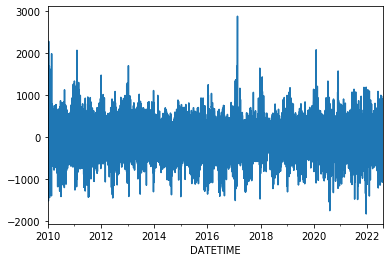

In [8]:
(forecast_demand.set_index('DATETIME').resample('1H').mean()['FORECASTDEMAND'] - actual_demand.set_index('DATETIME').resample('1H').mean()['TOTALDEMAND']).plot()

Evaluate the aemo model's performance

Mean Squared Error: 93038.16835459649
Root Mean Squared Error: 305.0215867026406
R-squared: 0.9461707823490928


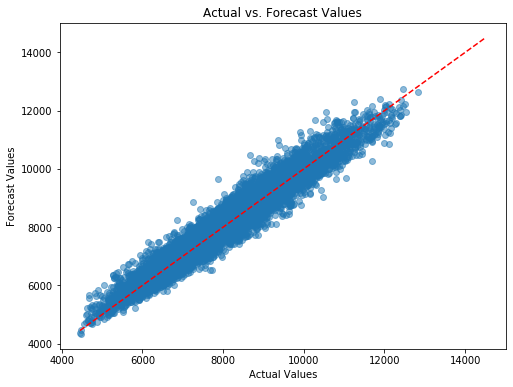

In [9]:
mse = mean_squared_error(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
r2 = r2_score(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Forecast Values")
plt.title("Actual vs. Forecast Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], [min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], color='red', linestyle='--')

plt.show()

Evaluate the aemo model's performance (across testing period)

In [10]:
# Evaluate the aemo model's performance
mse = mean_squared_error(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])
r2 = r2_score(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 96142.73431513214
Root Mean Squared Error: 310.0689186537924
R-squared: 0.9407544881212608


In [ ]:
describe = df.describe()

In [ ]:
describe.to_csv('../data/description.csv')

In [12]:
def calculate_r_squared(df, signal1, signal2, max_lag):
    result_df = pd.DataFrame(columns=['Lag', 'R-squared'])
    signal1 = df[signal1]
    signal2 = df[signal2]
    scaler = StandardScaler()
    for lag in range(-max_lag, 0 + 1):
        shifted_signal2 = np.roll(signal2, lag)
        signal1 = (signal1 - np.mean(signal1)) / (np.std(signal1) * len(signal1))
        shifted_signal2 = (shifted_signal2 - np.mean(shifted_signal2)) / (np.std(shifted_signal2) * len(signal1))
        r_squared = np.correlate(signal1, shifted_signal2, 'full')
        
#         r_squared = r2_score(z_score_signal1, z_score_shifted_signal2)
        result_df = result_df.append({'Lag': lag, 'R-squared': r_squared}, ignore_index=True)

    return result_df

In [13]:
# calculate_r_squared(df, 'TOTALDEMAND', 'TEMPERATURE_lagged', 10)

In [14]:
def run_regression_model(df, target, norm_columns, exclude_features=[]):
    feature_columns = [col for col in df.columns if col != target]
    feature_subset = [col for col in feature_columns if col not in exclude_features]
    print("Target: ", target)
    print("Features: ", feature_subset)
    
    keys = list(df.keys())
    norm_columns = [x for x in keys if x in norm_columns]

    df = df.dropna()

    train_data = df.loc[df.index <= test_date].copy()
    test_data = df.loc[df.index > test_date].copy()

    scaler = StandardScaler()
    train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
    test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

    X_train, y_train = train_data[feature_subset], train_data[target]
    X_test, y_test = test_data[feature_subset], test_data[target]

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    coefficients = model.coef_
    intercept = model.intercept_

    print("Coefficients:", coefficients)
    print("Intercept:", intercept)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    # Add a diagonal line for reference (perfect predictions)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()

Target:  TOTALDEMAND
Features:  ['Demand_Lagged', 'TEMPERATURE_lagged']
Mean Squared Error: 1483200.5877650587
Root Mean Squared Error: 1217.8672291202595
R-squared: 0.057896658128145484
Coefficients: [   0.27352121 -233.3037556 ]
Intercept: 5916.010034988725


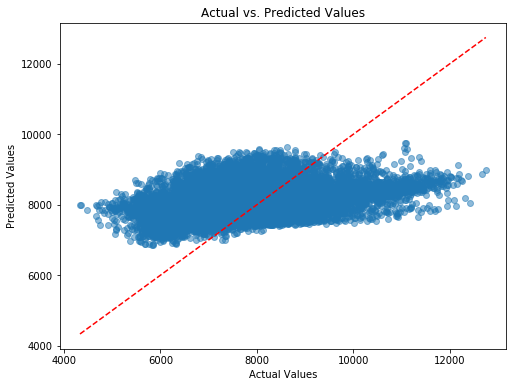

In [15]:
run_regression_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features=['Demand_Previous','Demand_Rolling'])

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged']
Mean Squared Error: 363736.8740114735
Root Mean Squared Error: 603.1060221979826
R-squared: 0.7689606332447654
Coefficients: [1061.17379917   57.23389827  118.89831439   -3.68333977]
Intercept: 8143.4774547731095


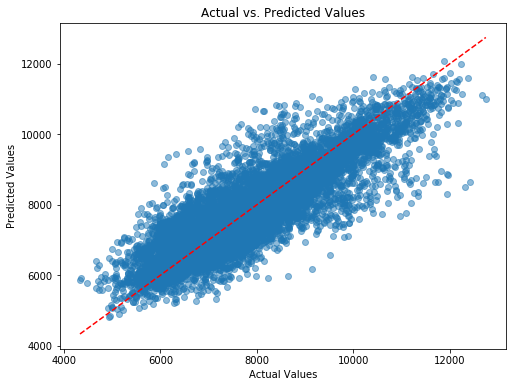

In [16]:
run_regression_model(data, 'TOTALDEMAND', norm_columns = ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged'])

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'Commercial_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'Price_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'IsWeekend', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Mean Squared Error: 273582.63560536515
Root Mean Squared Error: 523.0512743559327
R-squared: 0.8262250450761343
Coefficients: [ 5.57794543e-01  1.20915939e-01  3.58932156e-01  4.01735483e+01
  5.40710955e+01 -5.66574779e+00 -3.81250642e+00  1.18660587e+01
 -1.36384689e+02  4.33886059e+01  6.84376312e+01  1.38537016e+01
  

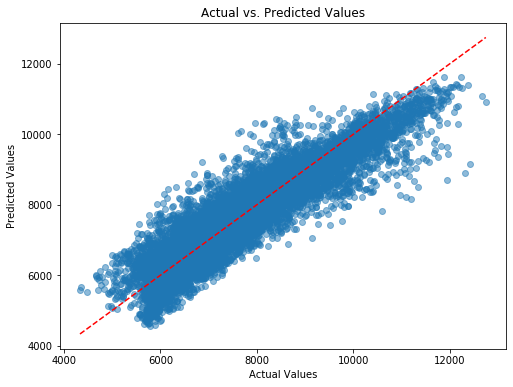

In [17]:
run_regression_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score)

In [18]:
def run_xdg_model(_df, target, norm_columns, exclude_features=[], n_estimators=1500):
    feature_columns = [col for col in _df.columns if col != target]
    feature_subset = [col for col in feature_columns if col not in exclude_features]
    print("Target: ", target)
    print("Features: ", feature_subset)
    if exclude_features != []:
        print("Excluded Features: ", exclude_features)
    
    keys = list(_df.keys())
    norm_columns = [x for x in keys if x in norm_columns]

    _df = _df.dropna()

    train_data = _df.loc[_df.index <= test_date].copy()
    test_data = _df.loc[_df.index > test_date].copy()

    scaler = StandardScaler()
    train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
    test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

    X_train, y_train = train_data[feature_subset], train_data[target]
    X_test, y_test = test_data[feature_subset], test_data[target]

    xgb_model = XGBRegressor(n_estimators=n_estimators, random_state=42)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")
    
    plt.figure(figsize=(16, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()
    
    data = {'Feature': feature_subset, 'Importance': xgb_model.feature_importances_}
    data = pd.DataFrame(data)
    
    print(data)
    
    plt.figure(figsize=(16, 10))
    plt.title("Feature Importance")
    plt.xticks(range(len(feature_subset)), feature_subset,rotation=45)
    plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
    plt.show()

Base Model

Target:  TOTALDEMAND
Features:  ['Demand_Lagged', 'TEMPERATURE_lagged']
Excluded Features:  ['Demand_Previous', 'Demand_Rolling']
Mean Squared Error: 1445462.8669467696
Root Mean Squared Error: 1202.2740398705985
R-squared: 0.08186700522132562


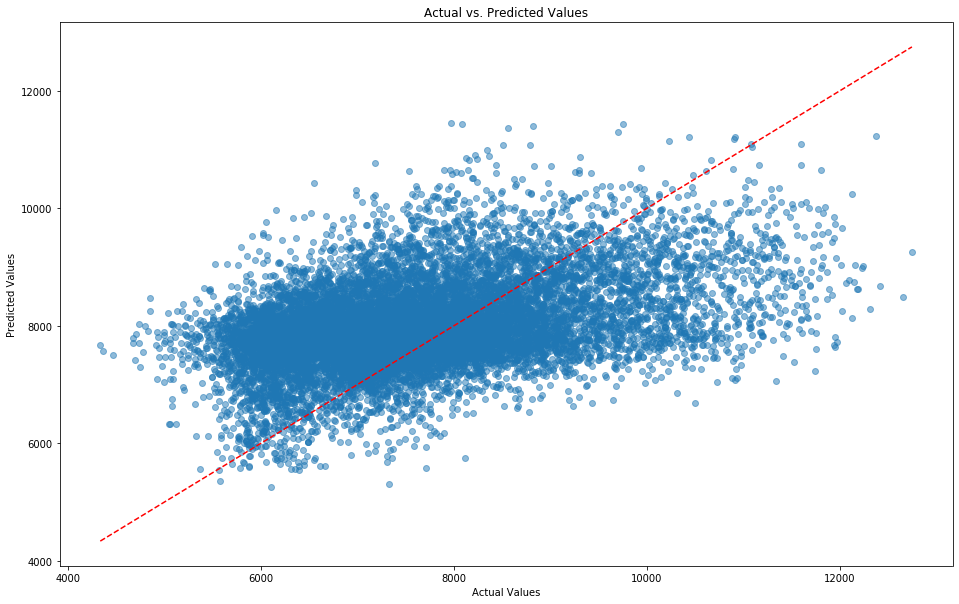

              Feature  Importance
0       Demand_Lagged    0.484213
1  TEMPERATURE_lagged    0.515787


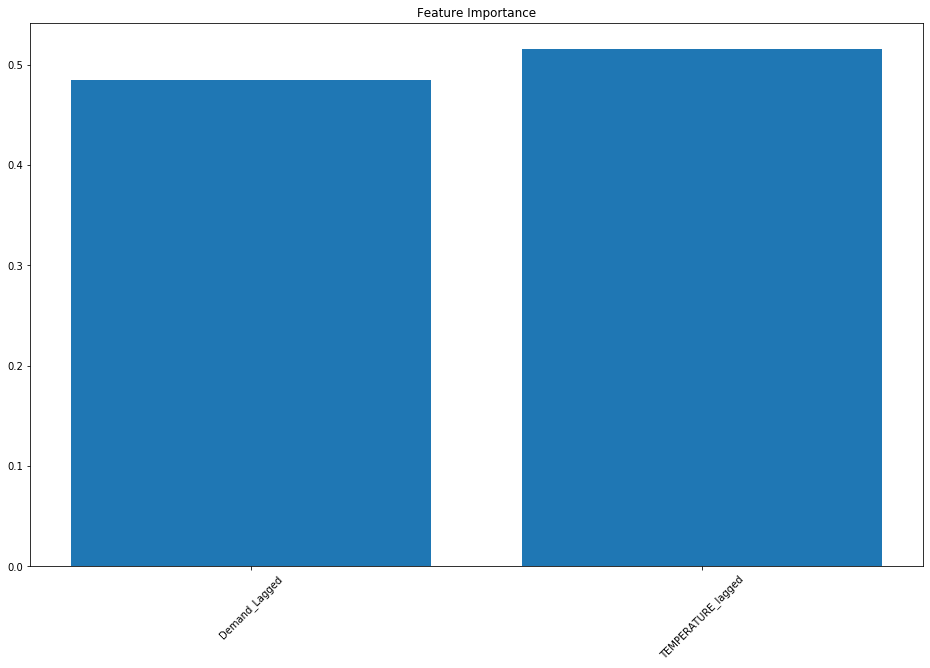

In [19]:
run_xdg_model(data, 'TOTALDEMAND', norm_columns = ['Demand_Lagged', 'TEMPERATURE_lagged'], exclude_features=['Demand_Previous','Demand_Rolling'], n_estimators=1500)

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged']
Mean Squared Error: 408663.0070036659
Root Mean Squared Error: 639.2675551001051
R-squared: 0.7404243311569265


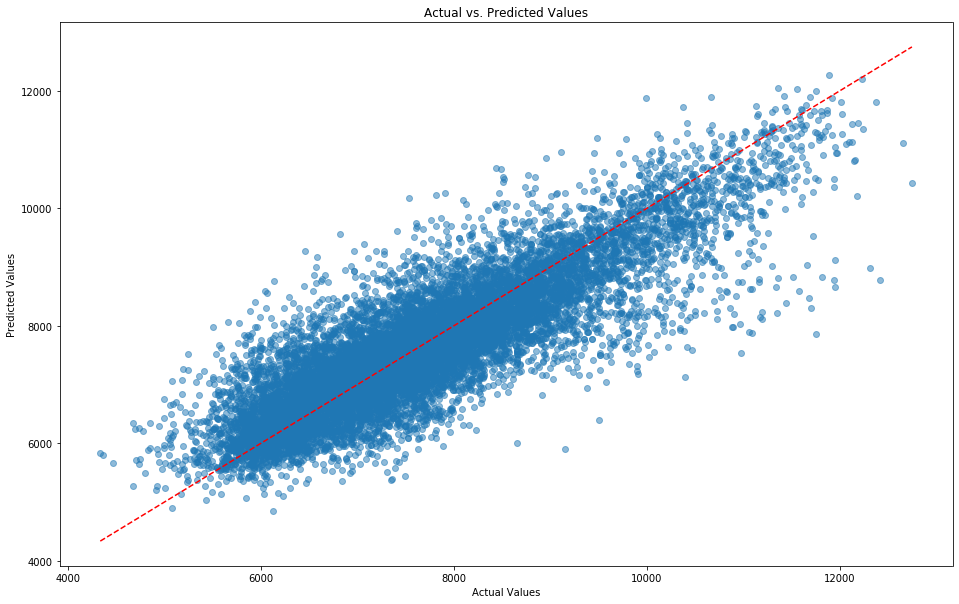

              Feature  Importance
0     Demand_Previous    0.798633
1       Demand_Lagged    0.057334
2      Demand_Rolling    0.072780
3  TEMPERATURE_lagged    0.071252


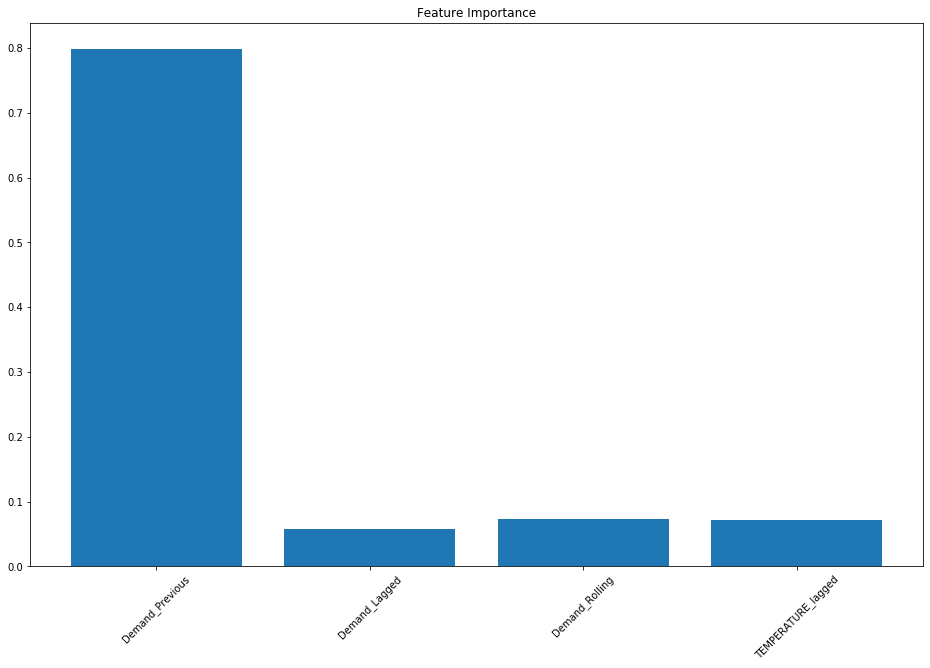

In [20]:
run_xdg_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=1500)

In [ ]:
for estimators in range(500, 2500, 250):
    run_xdg_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=estimators)

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'Exports_lagged', 'GDP_lagged', 'Residential_lagged', 'Commercial_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'Price_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'IsWeekend', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['CPI_lagged', 'Interest_lagged', 'CommPrice_lagged']
Mean Squared Error: 401379.5165728972
Root Mean Squared Error: 633.5451969456459
R-squared: 0.7450506782147164


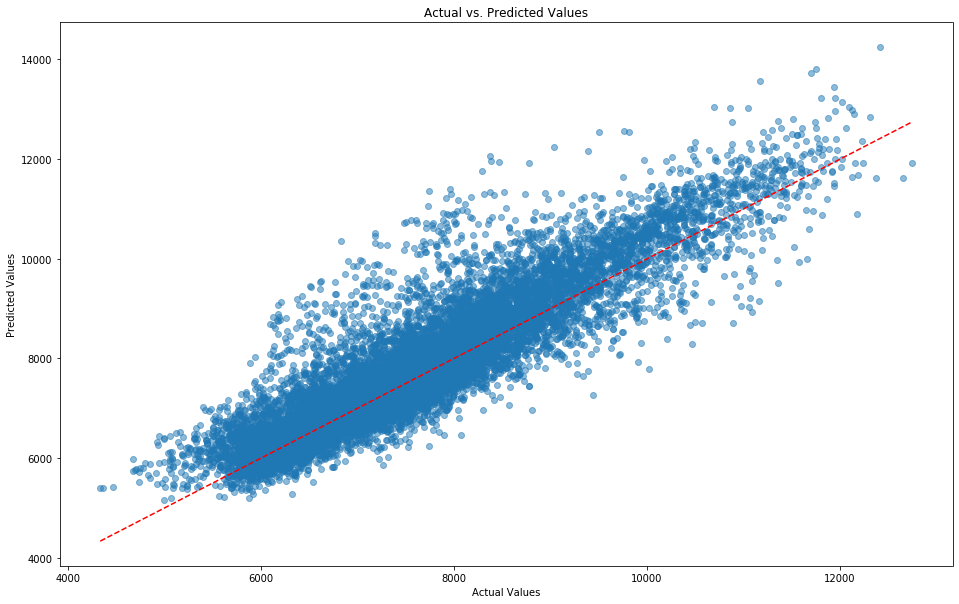

                Feature  Importance
0       Demand_Previous    0.092540
1         Demand_Lagged    0.004292
2        Demand_Rolling    0.005438
3    TEMPERATURE_lagged    0.005476
4        Exports_lagged    0.001949
5            GDP_lagged    0.004073
6    Residential_lagged    0.005054
7     Commercial_lagged    0.000000
8    SolarOutput_lagged    0.002988
9   Unemployment_lagged    0.003438
10         Price_lagged    0.001007
11             Rainfall    0.006135
12        SolarExposure    0.006368
13            DayOfYear    0.005769
14            IsWeekend    0.022908
15               Hour_0    0.022174
16               Hour_1    0.042848
17               Hour_2    0.064827
18               Hour_3    0.067967
19               Hour_4    0.065655
20               Hour_5    0.026443
21               Hour_6    0.010127
22               Hour_7    0.009042
23               Hour_8    0.004649
24               Hour_9    0.002442
25              Hour_10    0.005131
26              Hour_11    0

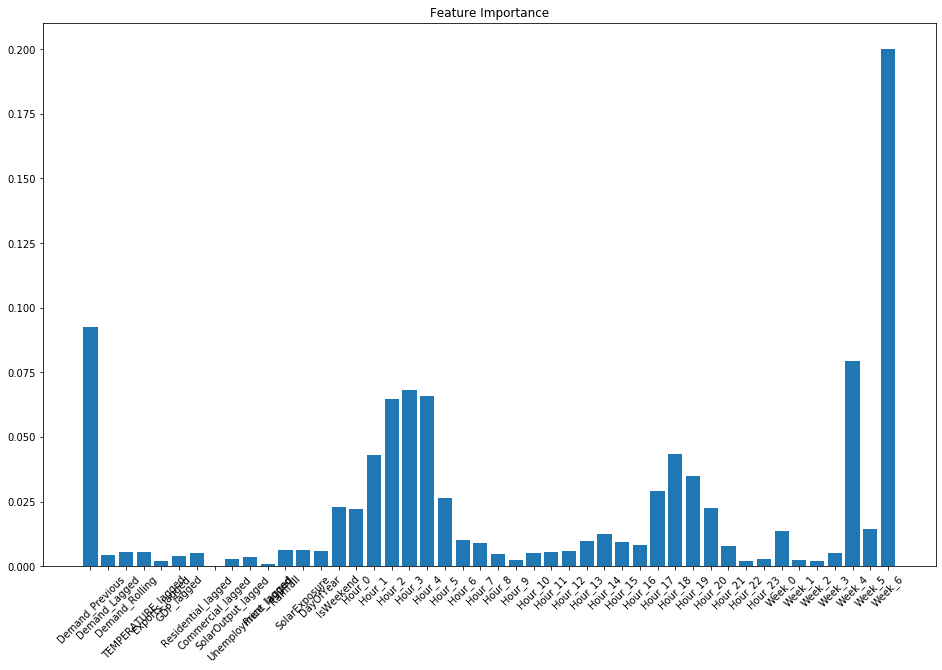

In [21]:
run_xdg_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features= [
                                                                               'CPI_lagged', 'Interest_lagged', 'CommPrice_lagged', 
#                                                                                'Exports_lagged', 'GDP_lagged',
#                                                                                'Residential_lagged', 'Commercial_lagged', 
#                                                                                 'SolarOutput_lagged',
#                                                                                'Unemployment_lagged', 'Price_lagged', 
#                                                                                 'Rainfall'
                                                                              ], n_estimators=2500)

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 537728.9557174501
Root Mean Squared Error: 733.3000448093878
R-squared: 0.6584438744283199


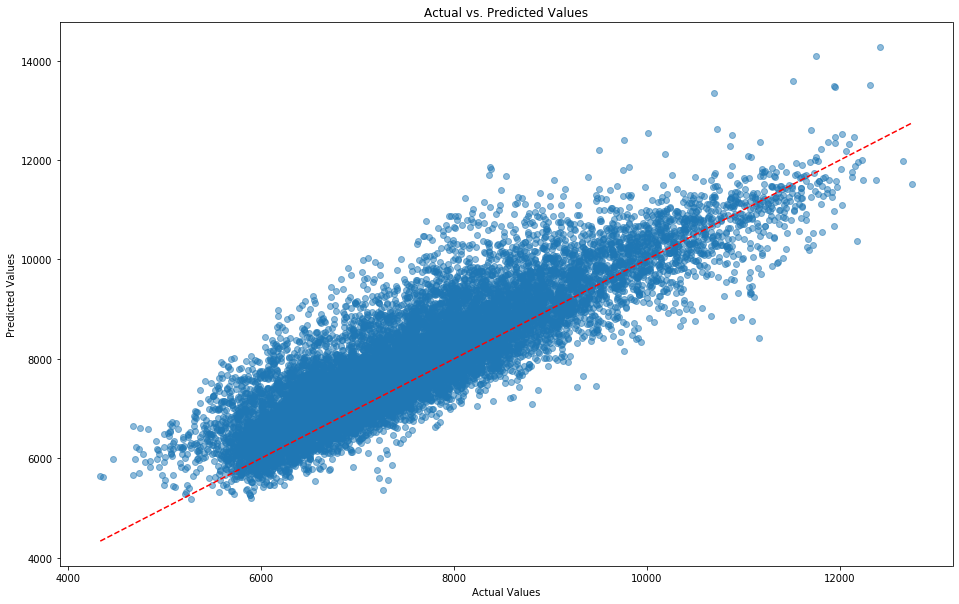

                Feature  Importance
0       Demand_Previous    0.086067
1         Demand_Lagged    0.003937
2        Demand_Rolling    0.005337
3    TEMPERATURE_lagged    0.005351
4            CPI_lagged    0.002928
5        Exports_lagged    0.002323
6            GDP_lagged    0.005472
7       Interest_lagged    0.011885
8    Residential_lagged    0.004685
9    SolarOutput_lagged    0.003389
10  Unemployment_lagged    0.003129
11     CommPrice_lagged    0.002481
12             Rainfall    0.006658
13        SolarExposure    0.006848
14            DayOfYear    0.006199
15               Hour_0    0.021976
16               Hour_1    0.048430
17               Hour_2    0.066401
18               Hour_3    0.062466
19               Hour_4    0.060001
20               Hour_5    0.035663
21               Hour_6    0.010779
22               Hour_7    0.009683
23               Hour_8    0.006508
24               Hour_9    0.003530
25              Hour_10    0.003853
26              Hour_11    0

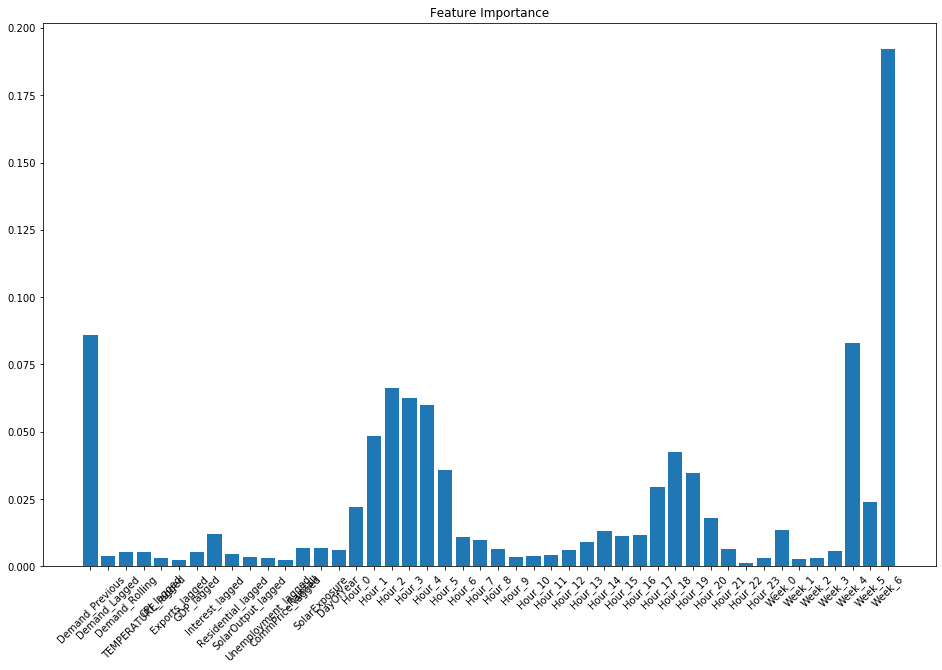

In [23]:
run_xdg_model(df,'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=4000, exclude_features= [
                                                                                    'Commercial_lagged', 'Residential_lagged', 
                                                                                    'IsWeekend', 'Price_lagged'
                                                                              ])

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['TOTALDEMAND', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 538387.304714641
Root Mean Squared Error: 733.7488021895783
R-squared: 0.6580257025401155


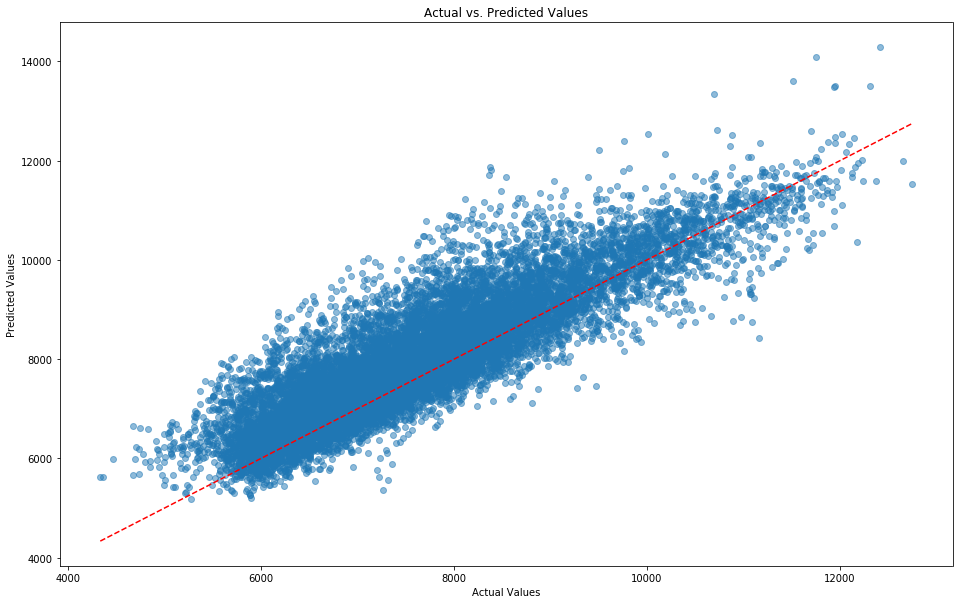

                Feature  Importance
0       Demand_Previous    0.092621
1         Demand_Lagged    0.004241
2        Demand_Rolling    0.005580
3    TEMPERATURE_lagged    0.005544
4            CPI_lagged    0.003098
5        Exports_lagged    0.002370
6            GDP_lagged    0.005785
7       Interest_lagged    0.011756
8    Residential_lagged    0.004630
9    SolarOutput_lagged    0.003494
10  Unemployment_lagged    0.003170
11     CommPrice_lagged    0.002559
12             Rainfall    0.006551
13        SolarExposure    0.006960
14            DayOfYear    0.006117
15               Hour_0    0.022915
16               Hour_1    0.052098
17               Hour_2    0.062324
18               Hour_3    0.059891
19               Hour_4    0.058660
20               Hour_5    0.037734
21               Hour_6    0.011352
22               Hour_7    0.009893
23               Hour_8    0.006837
24               Hour_9    0.003468
25              Hour_10    0.003943
26              Hour_11    0

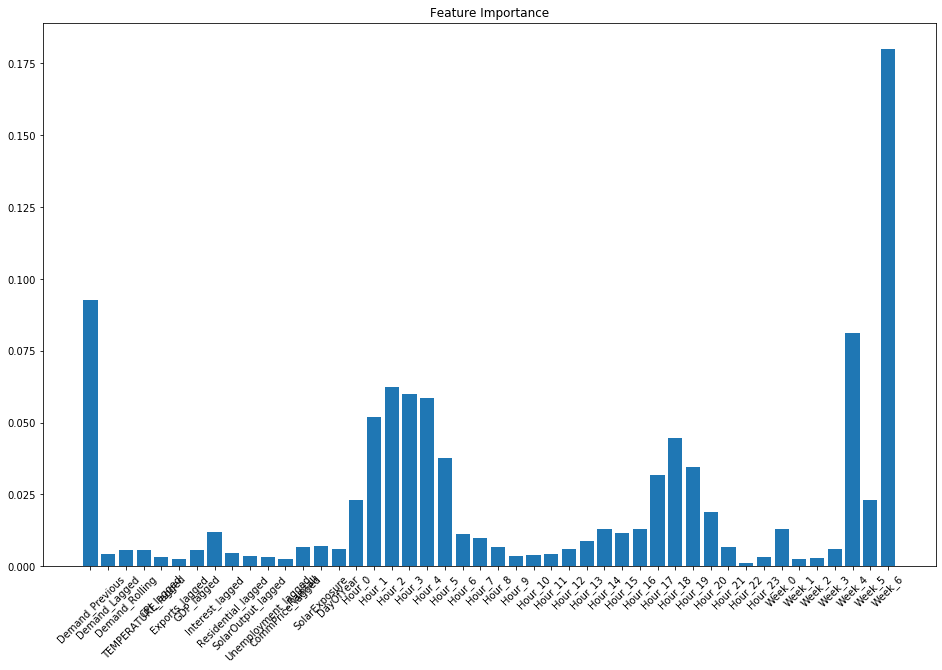

Target:  TOTALDEMAND
Features:  ['Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Demand_Previous', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 643500.5115093243
Root Mean Squared Error: 802.1848362499284
R-squared: 0.5912596129005767


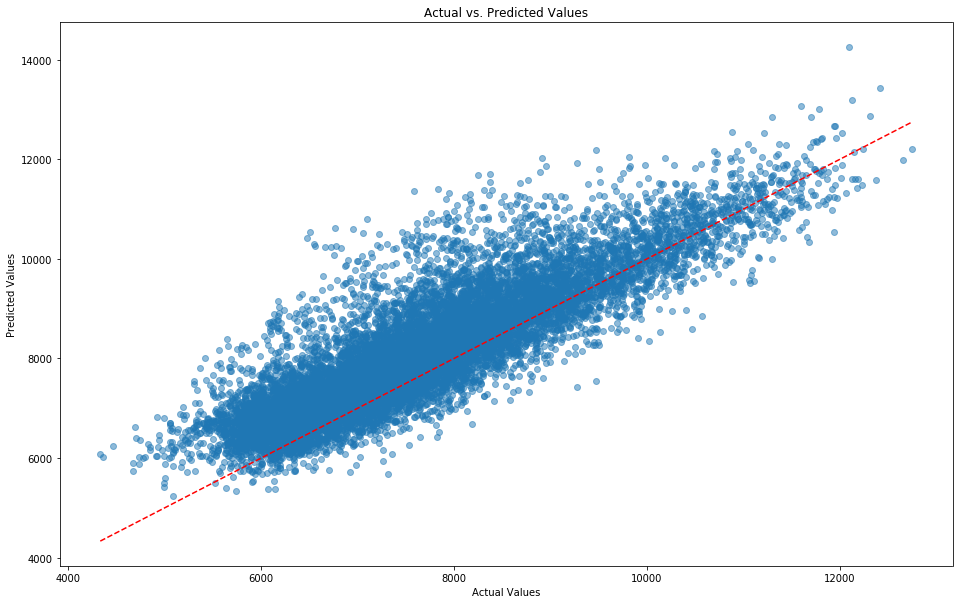

                Feature  Importance
0         Demand_Lagged    0.002414
1        Demand_Rolling    0.007708
2    TEMPERATURE_lagged    0.002871
3            CPI_lagged    0.000945
4        Exports_lagged    0.000736
5            GDP_lagged    0.001262
6       Interest_lagged    0.003083
7    Residential_lagged    0.003437
8    SolarOutput_lagged    0.001345
9   Unemployment_lagged    0.000885
10     CommPrice_lagged    0.001010
11             Rainfall    0.001828
12        SolarExposure    0.000980
13            DayOfYear    0.002271
14               Hour_0    0.030604
15               Hour_1    0.079993
16               Hour_2    0.132459
17               Hour_3    0.148615
18               Hour_4    0.149247
19               Hour_5    0.078126
20               Hour_6    0.012612
21               Hour_7    0.007259
22               Hour_8    0.009621
23               Hour_9    0.005352
24              Hour_10    0.003058
25              Hour_11    0.003599
26              Hour_12    0

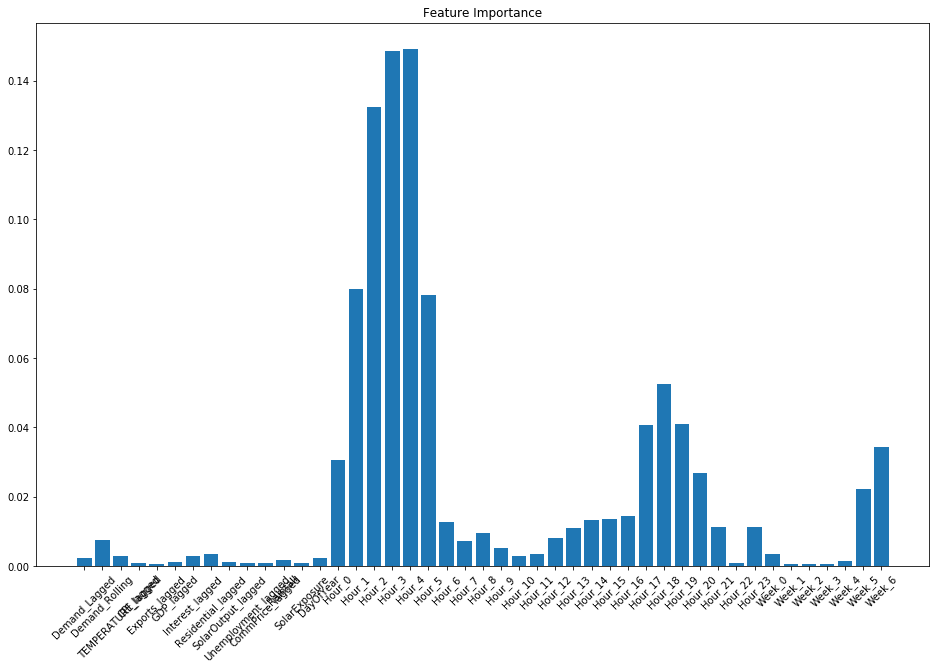

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Demand_Lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 1025463.8626954188
Root Mean Squared Error: 1012.6518961101187
R-squared: 0.34864310331084825


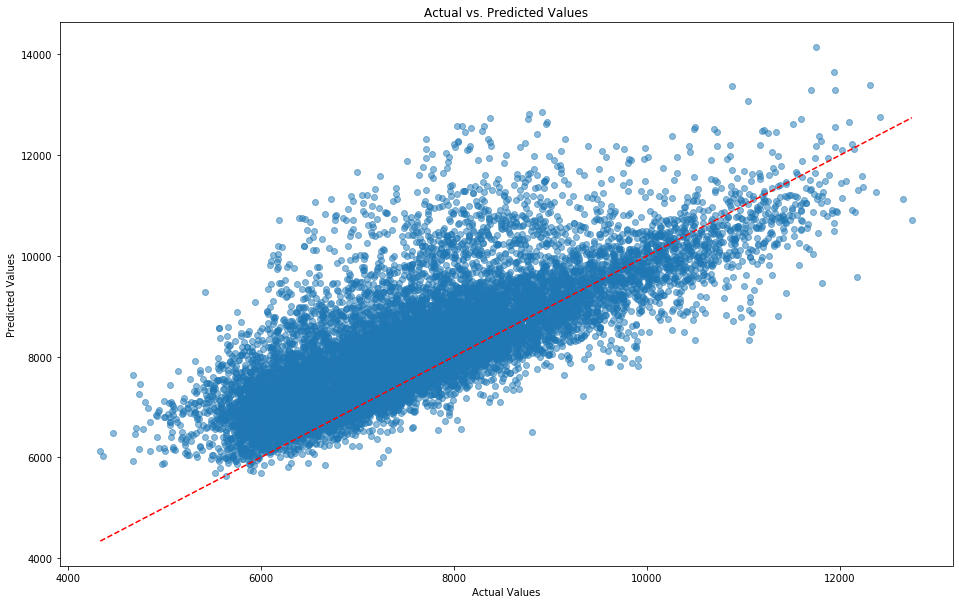

                Feature  Importance
0       Demand_Previous    0.091247
1        Demand_Rolling    0.006073
2    TEMPERATURE_lagged    0.005876
3            CPI_lagged    0.003941
4        Exports_lagged    0.004032
5            GDP_lagged    0.004857
6       Interest_lagged    0.014922
7    Residential_lagged    0.004962
8    SolarOutput_lagged    0.004904
9   Unemployment_lagged    0.004374
10     CommPrice_lagged    0.003568
11             Rainfall    0.008196
12        SolarExposure    0.008750
13            DayOfYear    0.008073
14               Hour_0    0.020738
15               Hour_1    0.046285
16               Hour_2    0.067760
17               Hour_3    0.066319
18               Hour_4    0.052595
19               Hour_5    0.030153
20               Hour_6    0.012953
21               Hour_7    0.010434
22               Hour_8    0.008462
23               Hour_9    0.003670
24              Hour_10    0.003562
25              Hour_11    0.003446
26              Hour_12    0

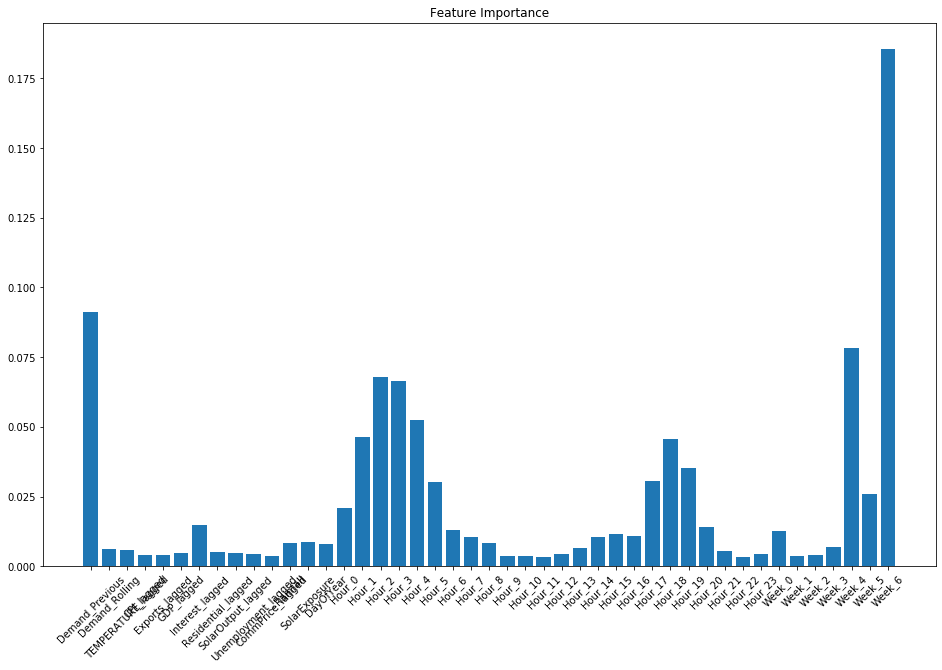

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Demand_Rolling', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 490415.4744198295
Root Mean Squared Error: 700.2967045615948
R-squared: 0.6884965788391547


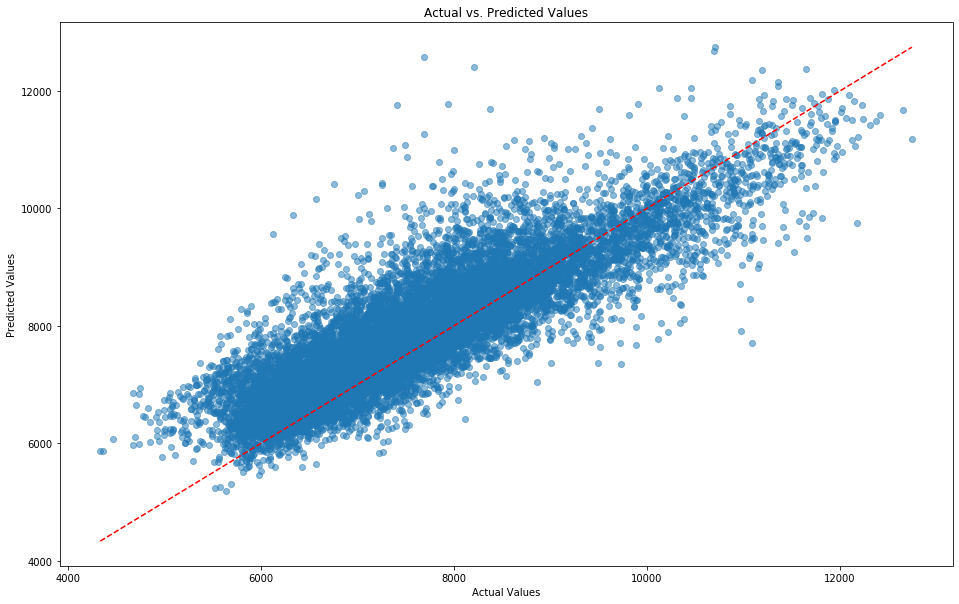

                Feature  Importance
0       Demand_Previous    0.088981
1         Demand_Lagged    0.005073
2    TEMPERATURE_lagged    0.005547
3            CPI_lagged    0.003953
4        Exports_lagged    0.002856
5            GDP_lagged    0.005565
6       Interest_lagged    0.007172
7    Residential_lagged    0.006802
8    SolarOutput_lagged    0.004622
9   Unemployment_lagged    0.003961
10     CommPrice_lagged    0.002778
11             Rainfall    0.007382
12        SolarExposure    0.006670
13            DayOfYear    0.007322
14               Hour_0    0.018178
15               Hour_1    0.045616
16               Hour_2    0.060879
17               Hour_3    0.066658
18               Hour_4    0.057330
19               Hour_5    0.030913
20               Hour_6    0.012514
21               Hour_7    0.012663
22               Hour_8    0.005534
23               Hour_9    0.005085
24              Hour_10    0.006206
25              Hour_11    0.006587
26              Hour_12    0

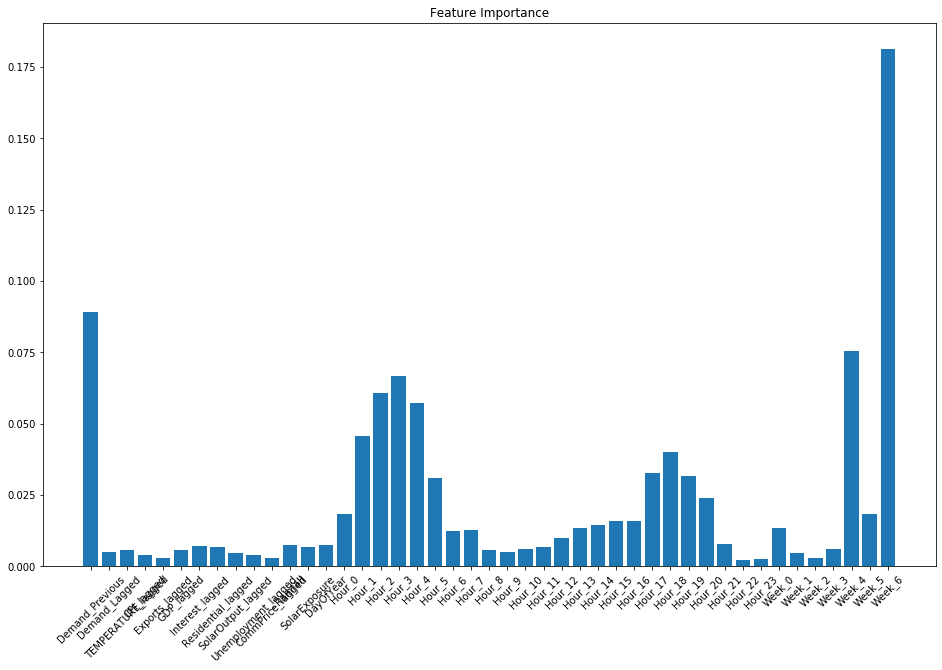

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['TEMPERATURE_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 359506.37304734637
Root Mean Squared Error: 599.5885030980384
R-squared: 0.7716477742349817


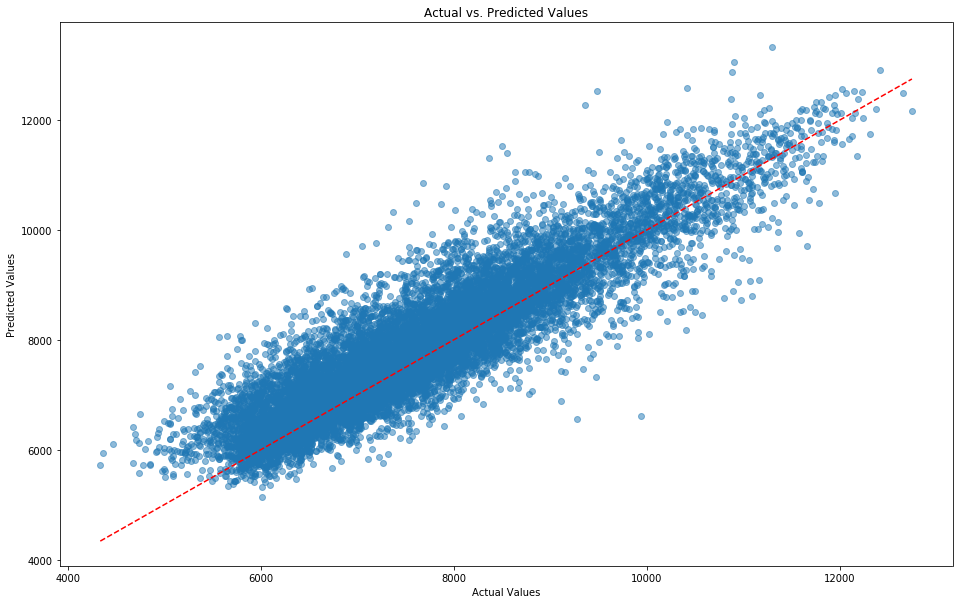

                Feature  Importance
0       Demand_Previous    0.089480
1         Demand_Lagged    0.005075
2        Demand_Rolling    0.005994
3            CPI_lagged    0.003071
4        Exports_lagged    0.002705
5            GDP_lagged    0.006630
6       Interest_lagged    0.008643
7    Residential_lagged    0.003882
8    SolarOutput_lagged    0.003930
9   Unemployment_lagged    0.002779
10     CommPrice_lagged    0.003294
11             Rainfall    0.006830
12        SolarExposure    0.006963
13            DayOfYear    0.009802
14               Hour_0    0.020208
15               Hour_1    0.050059
16               Hour_2    0.064609
17               Hour_3    0.062413
18               Hour_4    0.060723
19               Hour_5    0.032255
20               Hour_6    0.011920
21               Hour_7    0.010354
22               Hour_8    0.006464
23               Hour_9    0.004011
24              Hour_10    0.004074
25              Hour_11    0.005245
26              Hour_12    0

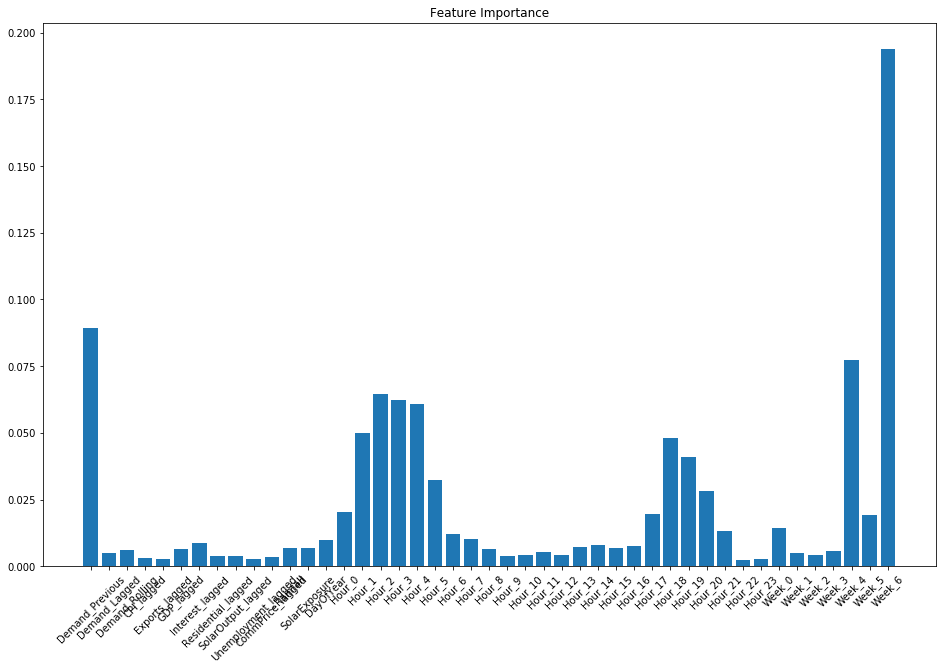

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['CPI_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 628982.6312899891
Root Mean Squared Error: 793.0842523275753
R-squared: 0.6004811191380712


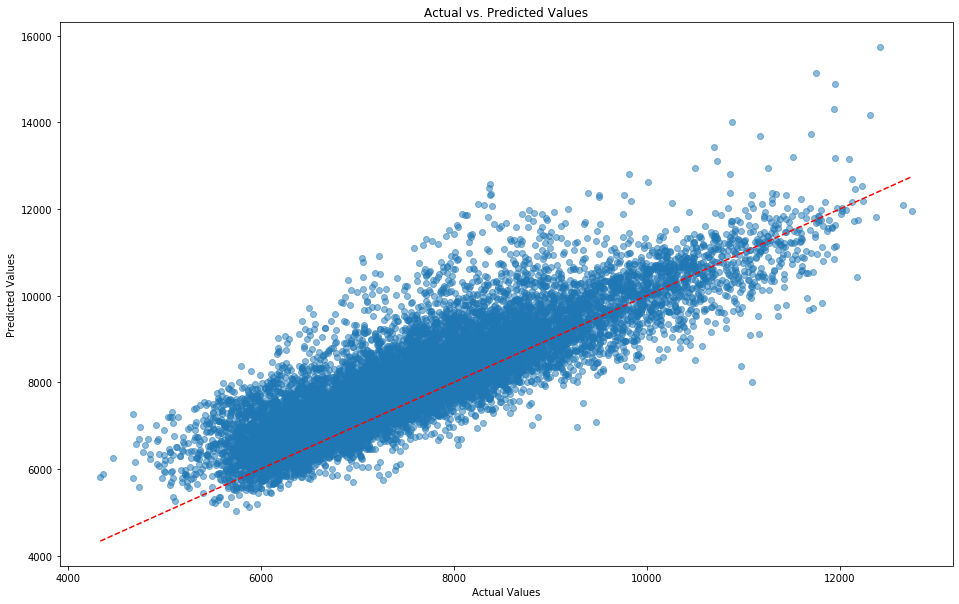

                Feature  Importance
0       Demand_Previous    0.091427
1         Demand_Lagged    0.004171
2        Demand_Rolling    0.005517
3    TEMPERATURE_lagged    0.005389
4        Exports_lagged    0.002052
5            GDP_lagged    0.004008
6       Interest_lagged    0.009004
7    Residential_lagged    0.003828
8    SolarOutput_lagged    0.004212
9   Unemployment_lagged    0.003341
10     CommPrice_lagged    0.002930
11             Rainfall    0.006979
12        SolarExposure    0.006788
13            DayOfYear    0.005926
14               Hour_0    0.023937
15               Hour_1    0.052723
16               Hour_2    0.065162
17               Hour_3    0.058270
18               Hour_4    0.054374
19               Hour_5    0.040886
20               Hour_6    0.013196
21               Hour_7    0.009986
22               Hour_8    0.006710
23               Hour_9    0.004413
24              Hour_10    0.004664
25              Hour_11    0.004973
26              Hour_12    0

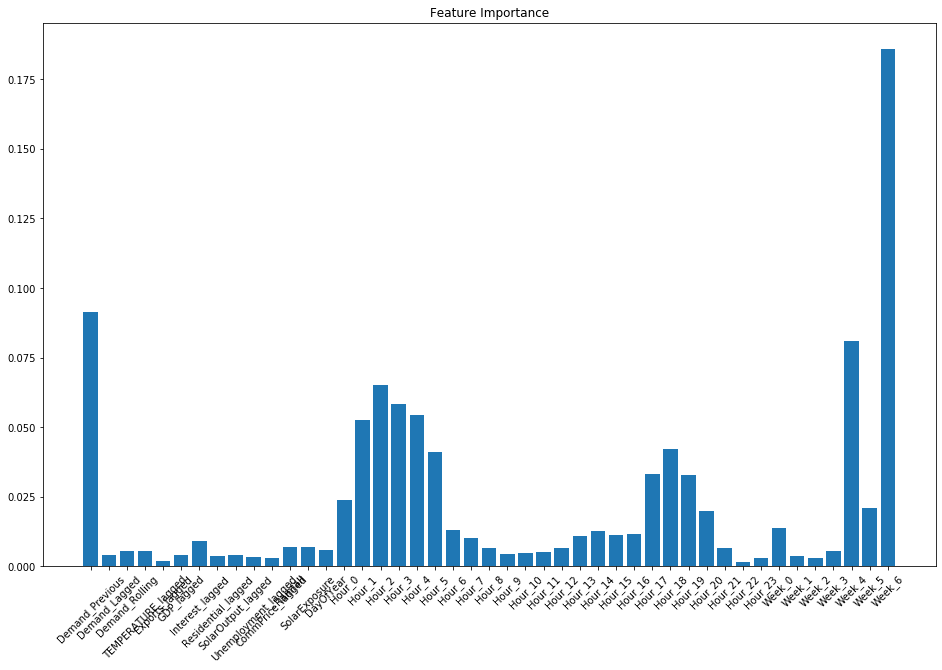

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Exports_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 997251.9491598607
Root Mean Squared Error: 998.625029307728
R-squared: 0.36656282249225614


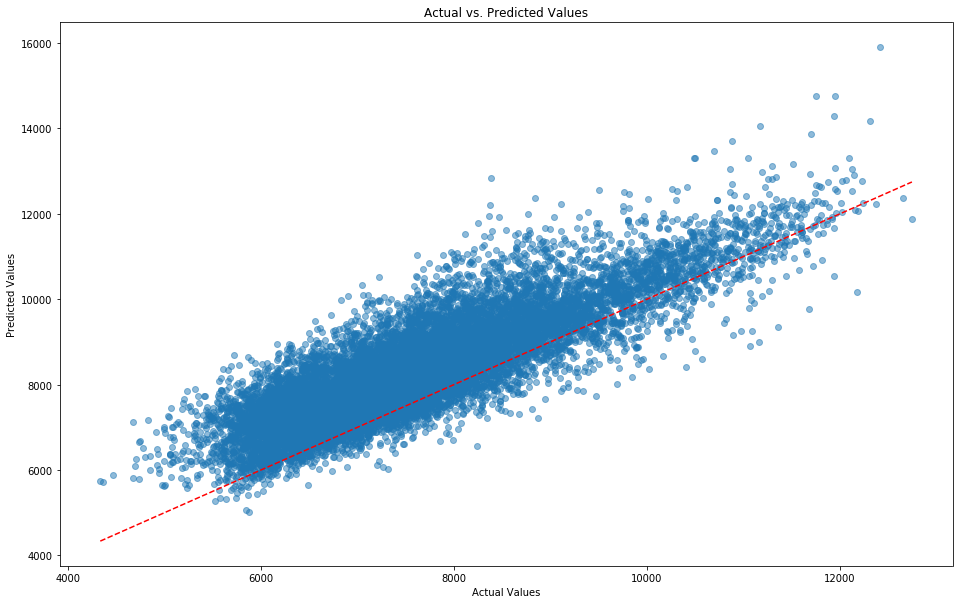

                Feature  Importance
0       Demand_Previous    0.092518
1         Demand_Lagged    0.004282
2        Demand_Rolling    0.005656
3    TEMPERATURE_lagged    0.005393
4            CPI_lagged    0.002720
5            GDP_lagged    0.003516
6       Interest_lagged    0.010439
7    Residential_lagged    0.004977
8    SolarOutput_lagged    0.003591
9   Unemployment_lagged    0.002934
10     CommPrice_lagged    0.002594
11             Rainfall    0.006351
12        SolarExposure    0.007023
13            DayOfYear    0.005984
14               Hour_0    0.024466
15               Hour_1    0.052308
16               Hour_2    0.063512
17               Hour_3    0.060810
18               Hour_4    0.054526
19               Hour_5    0.036121
20               Hour_6    0.011876
21               Hour_7    0.009597
22               Hour_8    0.007089
23               Hour_9    0.002895
24              Hour_10    0.004418
25              Hour_11    0.005355
26              Hour_12    0

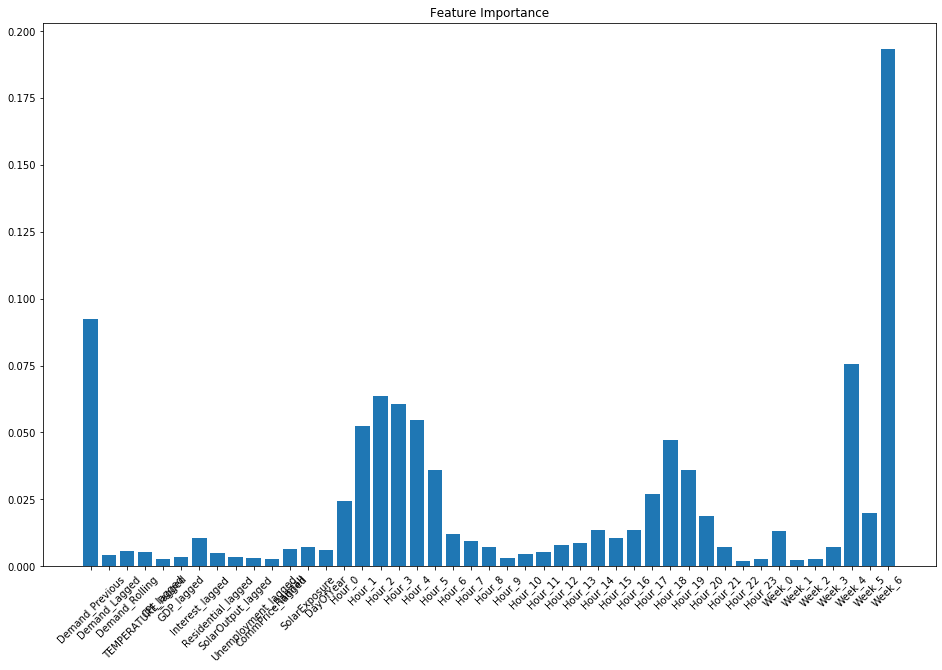

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['GDP_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 617571.9966744375
Root Mean Squared Error: 785.8574913267911
R-squared: 0.6077289567487536


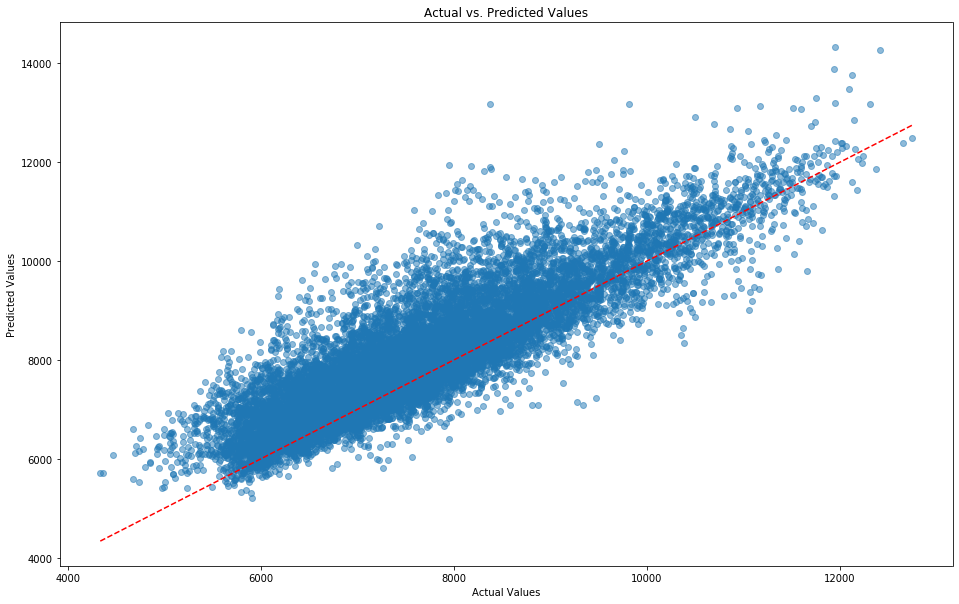

                Feature  Importance
0       Demand_Previous    0.091768
1         Demand_Lagged    0.004294
2        Demand_Rolling    0.005510
3    TEMPERATURE_lagged    0.005862
4            CPI_lagged    0.003089
5        Exports_lagged    0.002423
6       Interest_lagged    0.012859
7    Residential_lagged    0.005003
8    SolarOutput_lagged    0.004433
9   Unemployment_lagged    0.003855
10     CommPrice_lagged    0.002702
11             Rainfall    0.006421
12        SolarExposure    0.006682
13            DayOfYear    0.006014
14               Hour_0    0.024851
15               Hour_1    0.041997
16               Hour_2    0.059173
17               Hour_3    0.072305
18               Hour_4    0.060122
19               Hour_5    0.035347
20               Hour_6    0.012029
21               Hour_7    0.007628
22               Hour_8    0.005508
23               Hour_9    0.004138
24              Hour_10    0.003776
25              Hour_11    0.004925
26              Hour_12    0

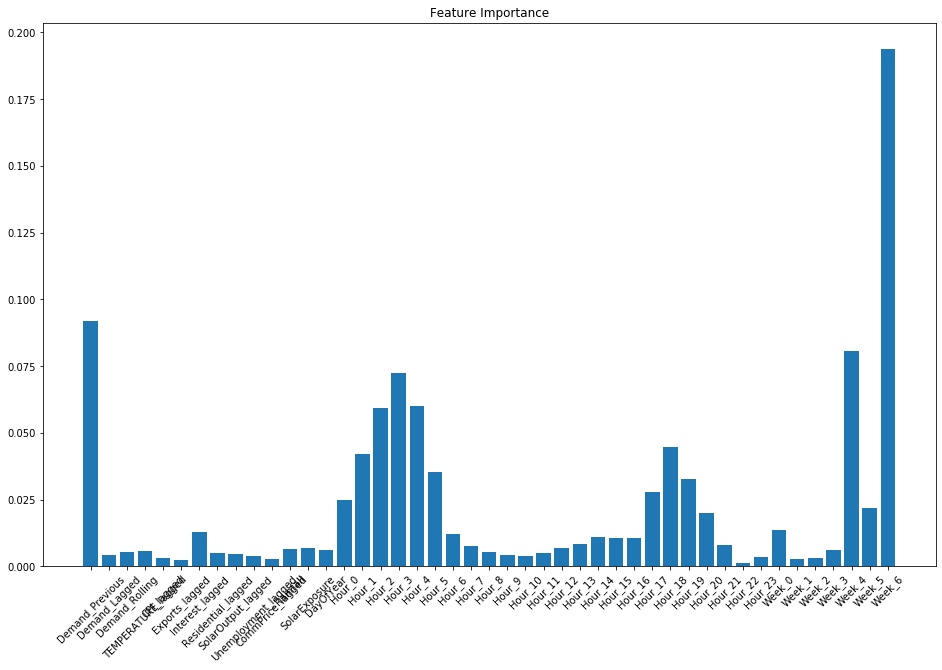

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Interest_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 593779.1208466674
Root Mean Squared Error: 770.5706462399586
R-squared: 0.6228417796635966


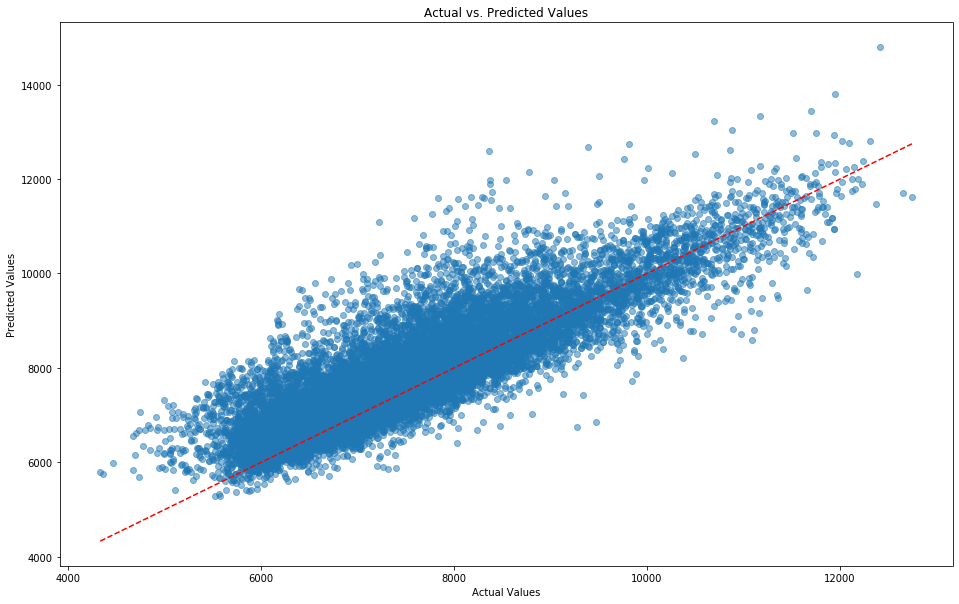

                Feature  Importance
0       Demand_Previous    0.089782
1         Demand_Lagged    0.004034
2        Demand_Rolling    0.005327
3    TEMPERATURE_lagged    0.005248
4            CPI_lagged    0.002987
5        Exports_lagged    0.002220
6            GDP_lagged    0.005237
7    Residential_lagged    0.006417
8    SolarOutput_lagged    0.003705
9   Unemployment_lagged    0.003526
10     CommPrice_lagged    0.002884
11             Rainfall    0.006572
12        SolarExposure    0.006740
13            DayOfYear    0.006127
14               Hour_0    0.023968
15               Hour_1    0.045856
16               Hour_2    0.065604
17               Hour_3    0.068169
18               Hour_4    0.067385
19               Hour_5    0.036670
20               Hour_6    0.011290
21               Hour_7    0.008080
22               Hour_8    0.006796
23               Hour_9    0.004054
24              Hour_10    0.003848
25              Hour_11    0.005254
26              Hour_12    0

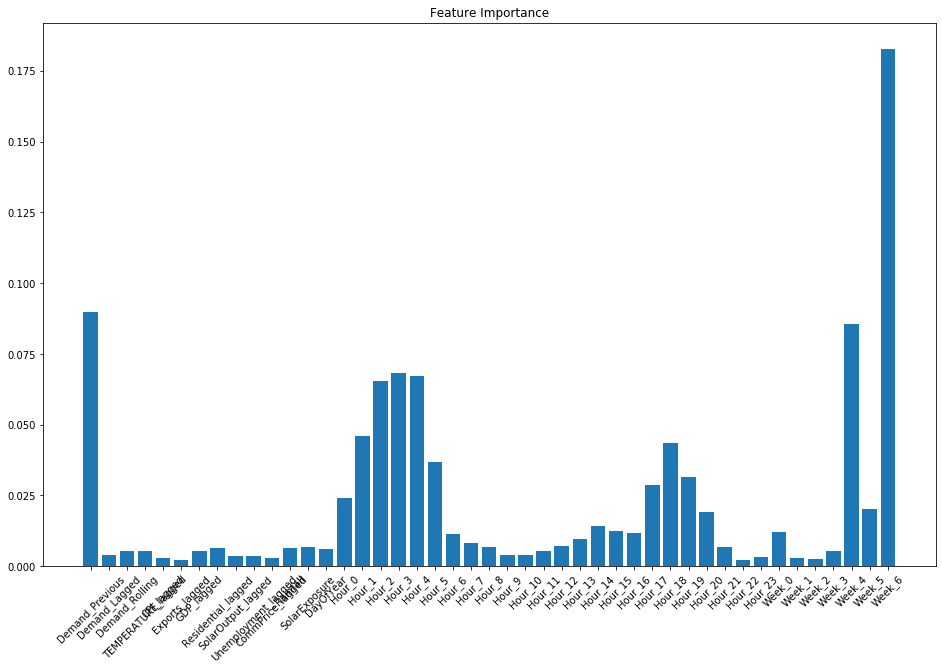

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Residential_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 772037.6770356547
Root Mean Squared Error: 878.6567458545201
R-squared: 0.5096150301003755


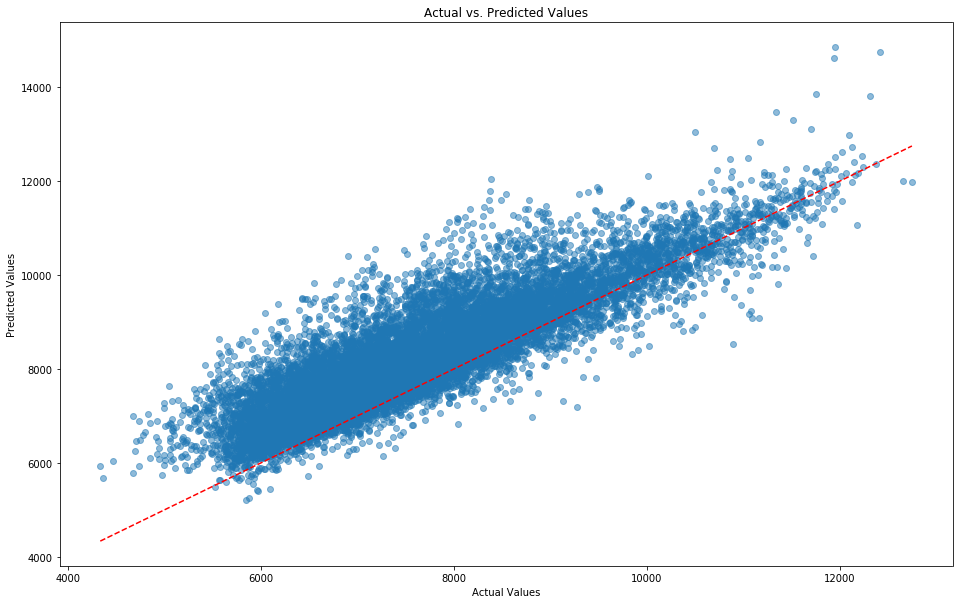

                Feature  Importance
0       Demand_Previous    0.091985
1         Demand_Lagged    0.004304
2        Demand_Rolling    0.005461
3    TEMPERATURE_lagged    0.005368
4            CPI_lagged    0.002822
5        Exports_lagged    0.002022
6            GDP_lagged    0.005602
7       Interest_lagged    0.011177
8    SolarOutput_lagged    0.004004
9   Unemployment_lagged    0.002974
10     CommPrice_lagged    0.002914
11             Rainfall    0.006820
12        SolarExposure    0.006667
13            DayOfYear    0.005767
14               Hour_0    0.022963
15               Hour_1    0.047453
16               Hour_2    0.063801
17               Hour_3    0.065194
18               Hour_4    0.058631
19               Hour_5    0.040166
20               Hour_6    0.012461
21               Hour_7    0.009552
22               Hour_8    0.005616
23               Hour_9    0.003807
24              Hour_10    0.004146
25              Hour_11    0.004528
26              Hour_12    0

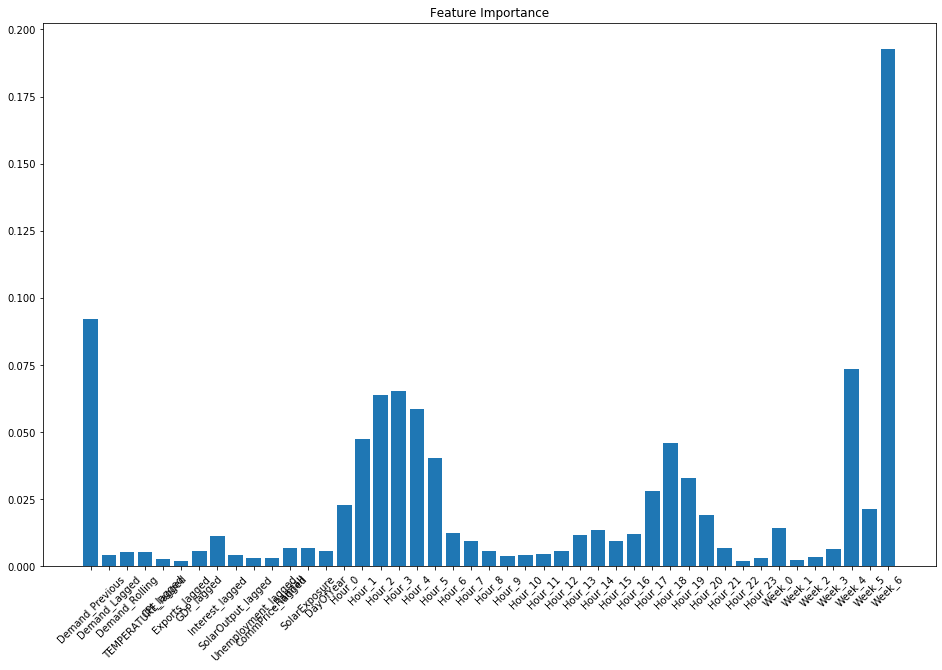

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Commercial_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 538387.304714641
Root Mean Squared Error: 733.7488021895783
R-squared: 0.6580257025401155


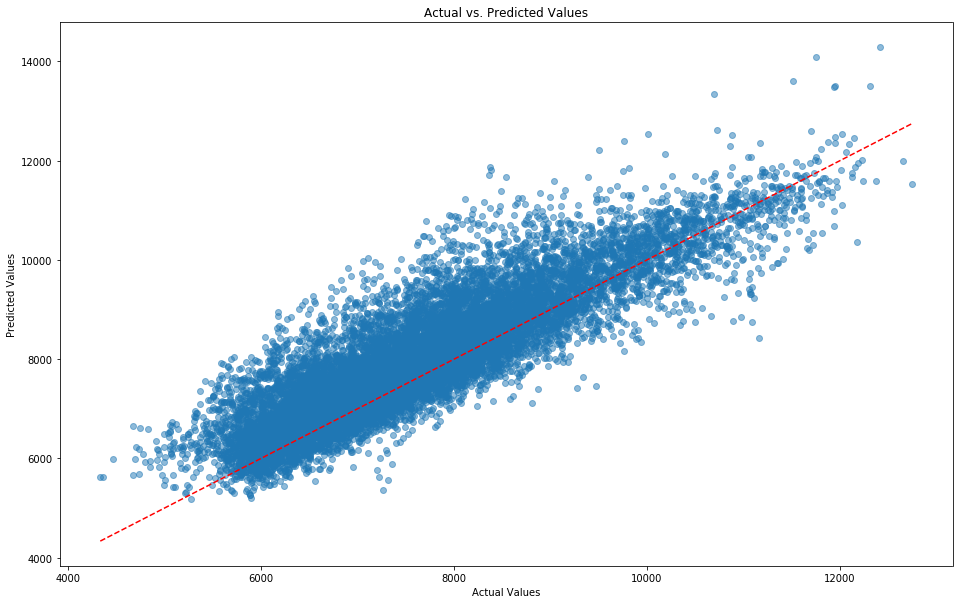

                Feature  Importance
0       Demand_Previous    0.092621
1         Demand_Lagged    0.004241
2        Demand_Rolling    0.005580
3    TEMPERATURE_lagged    0.005544
4            CPI_lagged    0.003098
5        Exports_lagged    0.002370
6            GDP_lagged    0.005785
7       Interest_lagged    0.011756
8    Residential_lagged    0.004630
9    SolarOutput_lagged    0.003494
10  Unemployment_lagged    0.003170
11     CommPrice_lagged    0.002559
12             Rainfall    0.006551
13        SolarExposure    0.006960
14            DayOfYear    0.006117
15               Hour_0    0.022915
16               Hour_1    0.052098
17               Hour_2    0.062324
18               Hour_3    0.059891
19               Hour_4    0.058660
20               Hour_5    0.037734
21               Hour_6    0.011352
22               Hour_7    0.009893
23               Hour_8    0.006837
24               Hour_9    0.003468
25              Hour_10    0.003943
26              Hour_11    0

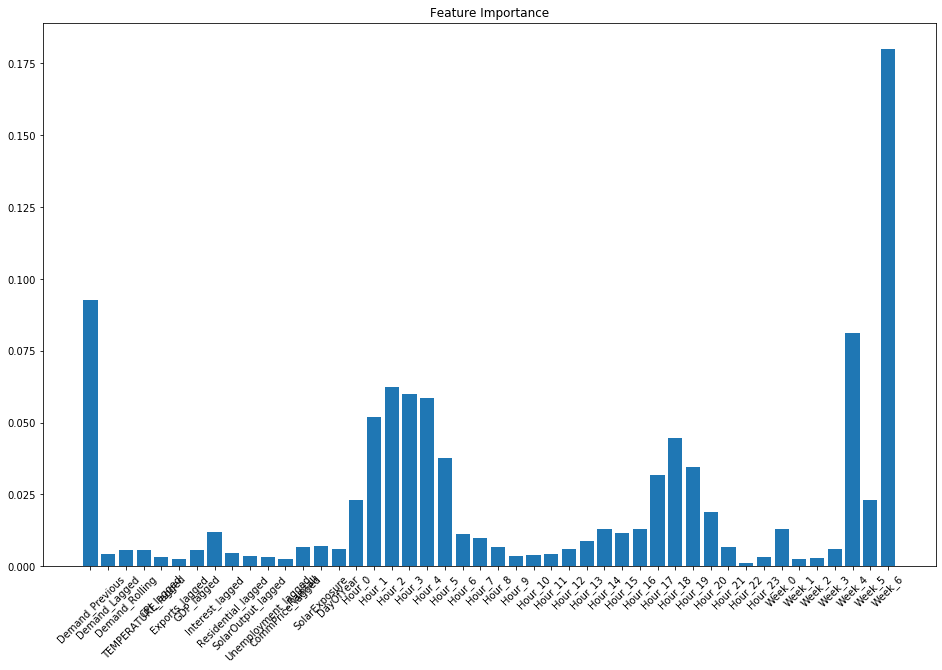

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['SolarOutput_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 849408.0255666878
Root Mean Squared Error: 921.6333466008529
R-squared: 0.4604707238520136


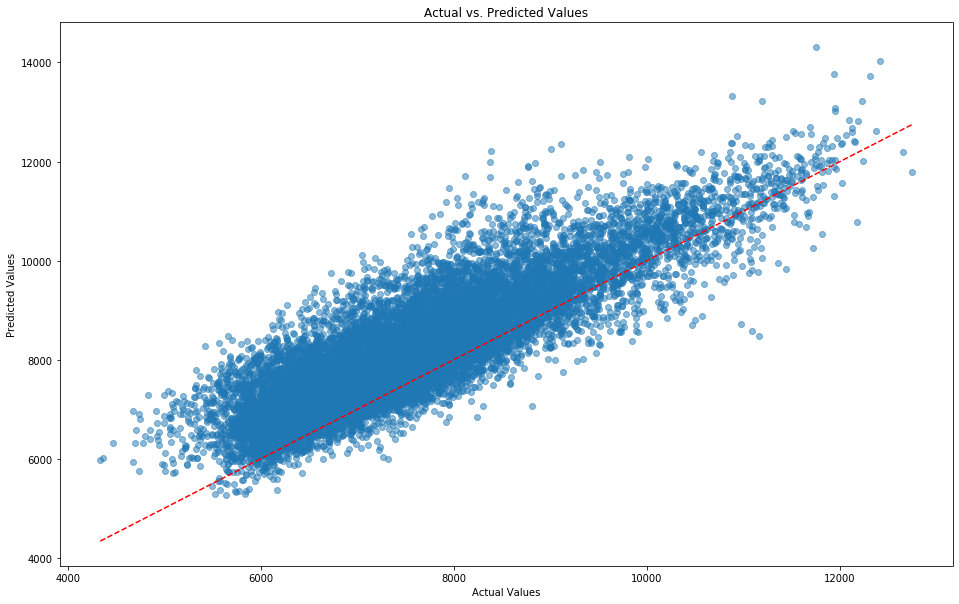

                Feature  Importance
0       Demand_Previous    0.090099
1         Demand_Lagged    0.004178
2        Demand_Rolling    0.005293
3    TEMPERATURE_lagged    0.005547
4            CPI_lagged    0.003122
5        Exports_lagged    0.002277
6            GDP_lagged    0.007046
7       Interest_lagged    0.011526
8    Residential_lagged    0.004964
9   Unemployment_lagged    0.002636
10     CommPrice_lagged    0.002438
11             Rainfall    0.007429
12        SolarExposure    0.006307
13            DayOfYear    0.006144
14               Hour_0    0.019121
15               Hour_1    0.049500
16               Hour_2    0.055681
17               Hour_3    0.068036
18               Hour_4    0.062278
19               Hour_5    0.034143
20               Hour_6    0.011847
21               Hour_7    0.010587
22               Hour_8    0.003529
23               Hour_9    0.003839
24              Hour_10    0.004253
25              Hour_11    0.005488
26              Hour_12    0

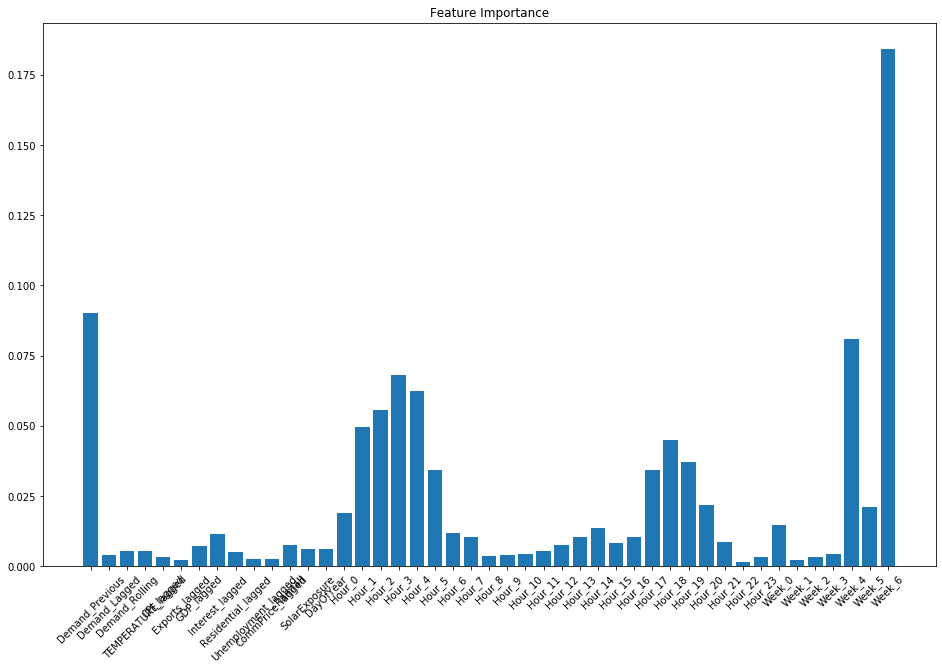

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Unemployment_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']
Mean Squared Error: 1104265.276570367
Root Mean Squared Error: 1050.8402716732771
R-squared: 0.29858980912514277


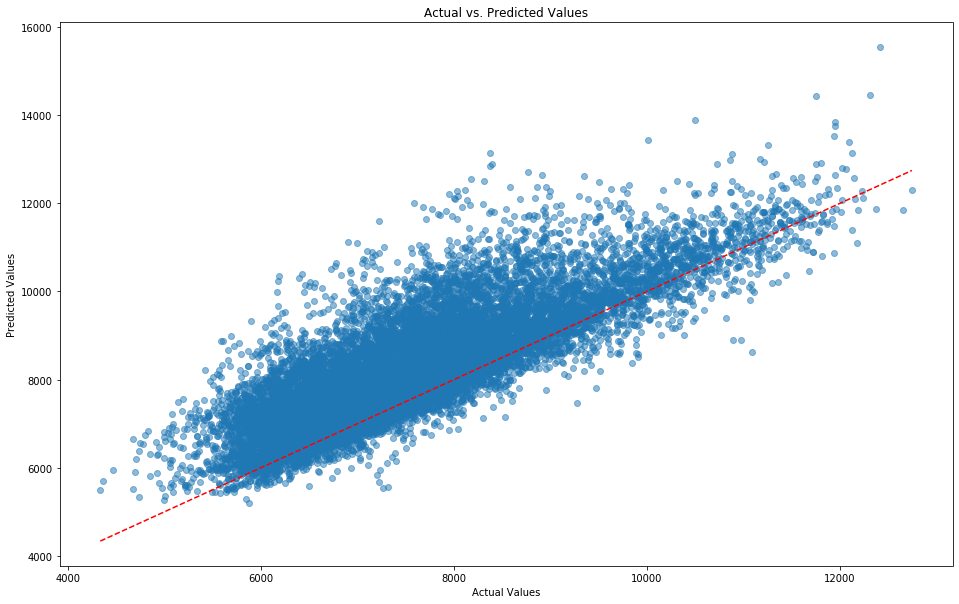

               Feature  Importance
0      Demand_Previous    0.091885
1        Demand_Lagged    0.004237
2       Demand_Rolling    0.005604
3   TEMPERATURE_lagged    0.005256
4           CPI_lagged    0.003233
5       Exports_lagged    0.002489
6           GDP_lagged    0.006257
7      Interest_lagged    0.009961
8   Residential_lagged    0.003697
9   SolarOutput_lagged    0.003879
10    CommPrice_lagged    0.002455
11            Rainfall    0.007180
12       SolarExposure    0.006997
13           DayOfYear    0.005931
14              Hour_0    0.021496
15              Hour_1    0.049436
16              Hour_2    0.064759
17              Hour_3    0.056404
18              Hour_4    0.057783
19              Hour_5    0.036758
20              Hour_6    0.011763
21              Hour_7    0.009143
22              Hour_8    0.005983
23              Hour_9    0.004027
24             Hour_10    0.004019
25             Hour_11    0.004589
26             Hour_12    0.007323
27             Hour_

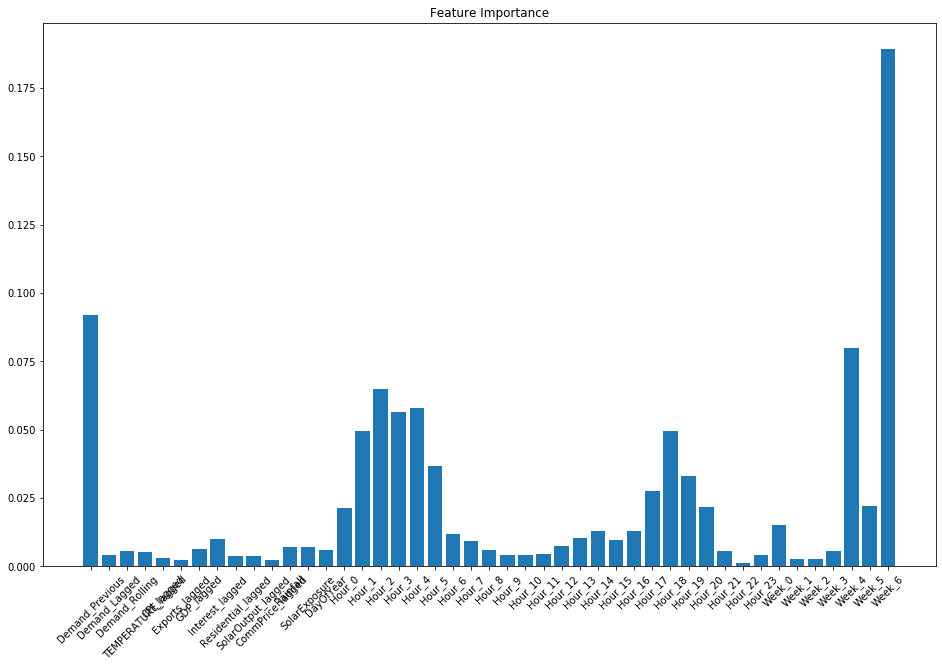

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'DayOfYear', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Week_0', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6']
Excluded Features:  ['Price_lagged', 'Commercial_lagged', 'IsWeekend', 'Price_lagged']


In [ ]:
for drop_features in list(df.keys()):
    run_xdg_model(df, 'TOTALDEMAND', To_Z_Score, exclude_features=[drop_features, 'Commercial_lagged', 'IsWeekend','Price_lagged'], n_estimators=3000)